# Using Data Science to Improve Business Cash Flow through Expense Reduction

### Background

Like any business, keeping expenses at bay while maintaining favorable cash flow is of optimal concern.  At my retail pharmacy, this concern is no different.  By far, the biggest challenge with regard to cash flow are our medication wholesaler bills.  I decided to take a look at those bills to see where potential savings could be found.  

The first concept I wanted to explore was exactly how much we were paying for medications.  We have a primary wholesaler who we obtain 95% of our medications from.  They present ease of ordering, frequent deliveries, and a localized distribution center.  However, we have discovered that there are cheaper alternatives for buying many generic medications versus what our main wholesaler offers.   

This presents an interesting dilemna.  

With this wholesaler, we have a contract that gives us a discount on expensive brand name medications based on the percentage of generic medications that we purchase each month. The higher our percentage (in dollars spent) in generics vs. brands, the larger the discount on brand name medications we will receive (ie - if our generic percentage is 14%, our discount on brands would be 1.9%).  Here's are our tiered discounts:

In [277]:
import pandas as pd
import numpy as np
from pandas import DataFrame

import dash
import dash_core_components as dcc
import dash_bootstrap_components as dbc
import dash_html_components as html
import dash_table as dt
from dash.dependencies import Input, Output, State

import flask

import plotly.express as px
import plotly.graph_objs as go

import matplotlib.pyplot as plt

import time
import datetime

import warnings

warnings.filterwarnings('ignore')

tiers = pd.read_csv('/Users/adam/Desktop/Data/kinray/tiers.csv')

pd.set_option('display.max_columns', None)

#May 2021 Trxade ordering
may_trx = pd.read_csv('/Users/adam/Desktop/Data/kinray/may_trx.csv')
may_trx.rename(columns={'KINRAY PRICE':'Kinray_May'}, inplace=True)
#(Note: Trxade pricing dataframe already includes Kinray discounted price)

#kinray pricing
kinray = pd.read_csv('/Users/adam/Desktop/Data/kinray/kinray.csv')
kinray.rename(columns={'Description':'item','Ext Cost':'total', 'Cost':'price', 'Ship Qty':'kin_qty'}, inplace=True)
kinray['price'] = kinray['price'].str.replace('$','')
kinray['price'] = kinray['price'].str.replace(',','')
kinray['price'] = kinray['price'].astype(float)

#kinray discounted pricing
kinray['net_price'] = kinray['price']*.25

kinray['total'] = kinray['total'].str.replace('$','')
kinray['total'] = kinray['total'].str.replace(',','')
kinray['total'] = kinray['total'].astype(float)

#kinray discounted total
kinray['net_total'] = kinray['total']*.25

#import RXs from 2020
LTC = pd.read_csv('/Users/adam/Desktop/Data/rxs/LTC20.csv')
RET = pd.read_csv('/Users/adam/Desktop/Data/rxs/RET20.csv')

rx = pd.concat([LTC,RET])
rx.rename(columns={'Drug Name':'Name', 'Total Paid':'Total_Paid'}, inplace=True)

#import all brands from 1/1/20-7/31/21
b1 = pd.read_csv('/Users/adam/Desktop/Data/rxs/ltcbrand010120073121.csv', skiprows=2)
b2 = pd.read_csv('/Users/adam/Desktop/Data/rxs/retailbrand010120073121.csv', skiprows=2)

brands = pd.concat([b1,b2])

#rename columns as df reset index(?) for some reason during concat
brands.rename(columns={'Cost':'Plan', '%Off AWP/Status':'Name'}, inplace=True)

#All brands have a "Y" for the "Brand" column unless they are cash.  
#For some reason datascan has a lot of OTCs (which are cash) as brand
brands['Brand'] = np.where(brands['Plan'] != 'C', 'Y', 'N')

rx['Total_Paid'] = rx['Total_Paid'].str.replace('$','')
rx['Total_Paid'] = rx['Total_Paid'].str.replace(',','')
rx['Total_Paid'] = rx['Total_Paid'].astype(float)

rx['Brand'] = rx.Name.map(brands.set_index('Name')['Brand'].to_dict())
rx.Brand.fillna('N', inplace=True)

#groupby function used to determine the highest dollar amount per med by volume
by_cost = rx.groupby(['Name'])[['Total_Paid']].sum().reset_index()
by_cost['Brand'] = by_cost.Name.map(brands.set_index('Name')['Brand'].to_dict())
by_cost.sort_values('Total_Paid', ascending=False)

#groupby function used to determine the sum of brands vs. generics
by_brand = rx.groupby(['Brand'])[['Total_Paid']].sum().reset_index()

tiers

,Generic/Brand Percentage,Brand Discount
0,9%,1.56%
1,12%,1.70%
2,14%,1.90%
3,16%,2.10%
4,18%,2.25%
5,22%,2.50%
6,25%,3.00%


The wholesaler does this to encourage generic purchases, which in certain cases presents a large spread for them as a wholesaler (conversely the wholesaler does not enjoy this advantage with the brand name medications not to mention the fact that their own brand name purchases most likely present a similar cash flow challenge on their end as well).  As shown below, in 2020, while brand name medications made up 10% of our prescriptions volume-wise, they make up >65% of our purchases dollar-wise.  

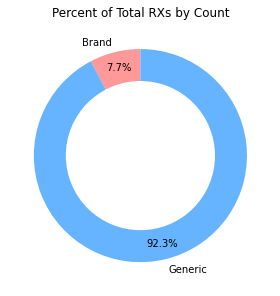

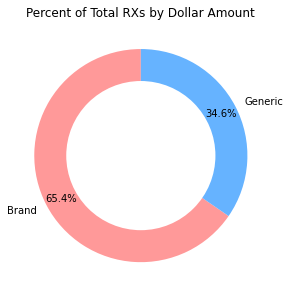

In [278]:
# Data to plot

labels = ['Brand', 'Generic']

sizes = [65.4, 34.6]
size_count = [7.7,92.3]

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

ax1 = plt.pie(size_count, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.tight_layout()
plt.title("Percent of Total RXs by Count")
plt.show()
 
ax2 = plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.tight_layout()
plt.title("Percent of Total RXs by Dollar Amount")
plt.show()

Needless to say the brand name discount is an important factor in our purchasing methodology. The conundrum lies in this thought - as a purchaser, do I overpay for generics in order to get that discount on the expensive brand name products I need to buy?  Or does buying the generics from an alternate source outweigh the potential brand name discount savings?  

The second concept I wanted to dive into was if our pharmacy was over-ordering expensive medications.  Simply put, too much ordering would affect cash flow with dollars essentially sitting on our shelves, unnecessarily, in the form of unused medication. 

I decided to analyze both of these ideas using data science.  

If you are familiar with coding and would like to toggle the raw code used to find these results, click the button below:

In [319]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Methodology

Concept One:

Over one month, I purchased a large number of generic medications from alternate wholesalers with cheaper pricing.  These would have normally been purchased through our primary wholesaler.  After the month, I compared the savings obtained through alternate purchasing vs our "normal" purchasing.  I then compared the savings in generic purchasing vs the brand name discount that resulted.  Here is a snippet of what was ordered through alternative purchasing:

In [279]:
may_trx.head()

,Order Date,Supplier Name,NDC,Type,Product Name,Pack Size,Strength,MFR,Dosage Form,Item Price,Kinray_May,Kinray Total,Quantity Ordered,Quantity Processed,Shipping Fee,Total Cost,Total Processed
0,2021-05-11 18:43:19,Bonita (ADD),69097051403,G,Abacavir 300mg Tablet,60 ea,300mg mg,Cipla,Tab,$9.23,$25.46,$76.38,3,3,$0.00,$27.69,$27.69
1,2021-05-27 18:40:28,River City/MRX (ADD),904598463,G,Ammonium Lactate 12% Topical Lotion,396 g,12% %,Major,Lotion,$6.11,$32.70,$327.00,10,10,$0.00,$61.10,$61.10
2,2021-05-20 13:19:49,NDC Distributors (ADD),67877043305,G,Aripiprazole 15mg Tablet,500 ea,15mg mg,Ascend Lab,Tab,$16.95,$100.00,$100.00,1,1,$0.00,$16.95,$16.95
3,2021-05-20 13:19:47,Bonita (ADD),66689073505,G,Aripiprazole 1mg/mL Solution,150 ml,1mg mg,Vistapharm,Sol,$113.38,$145.90,$437.70,3,3,$0.00,$340.14,$340.14
4,2021-05-20 13:19:48,CityMedRx (ADD),13668021705,G,Aripiprazole 5mg Tablet,500 ea,5mg mg,Torrent,Tab,$8.99,$119.96,$119.96,1,1,$0.00,$8.99,$8.99


First, I gathered the cost from our primary wholesaler.  I took previous prescription fills for the same NDCs that we ordered through the cheaper, secondary wholesaler and matched those up (this took some cleaning as leading zeros on NDCs tend to get knocked off).  If there were no previous fills, I manually searched our wholesaler catalog and obtained pricing (unfortunately - and understandably - no public API exists for the wholesaler that would have allowed me to obtain the pricing through coding).  I then compared the total amount spent while adding in the discounts based on the above tier to see where we fell with spending. 


Concept Two:

I analyzed six months of purchases from all medications that cost over $10,000 and compared those purchases to the number of prescriptions filled over that same time period for those same medications.  If there was a net difference (ie - 5 bottles purchased and only 3 prescriptions filled), it was noted.  Here is a snippet of the compilation of total volume of medicine filled over that time period:

In [258]:
#Compiling a list of NDCs which will be used as identifiers and a link between RXs filled from the pharmacy software and the medications ordered from the wholesaler
ret_ndc = pd.read_csv('/Users/adam/Desktop/Data/ret_ndc_usage.csv')
ltc_ndc = pd.read_csv('/Users/adam/Desktop/Data/ltc_ndc_usage.csv')
ndc = pd.concat([ret_ndc,ltc_ndc])
ndc['NAME'] = ndc['NAME'].str.strip()
ndc['NDC'] = ndc['NDC'].astype(str)

#Compiling a list of RXs filled from Jan-Aug 2021
ltc = pd.read_csv('/Users/adam/Desktop/Data/rxs/LTC21_thru0831.csv', skiprows=2)
ret = pd.read_csv('/Users/adam/Desktop/Data/rxs/RET21_thru0831.csv', skiprows=2)
rxs = pd.concat([ltc,ret])

#rename columns as df reset index(?) for some reason during concat
rxs.rename(columns={'Rx Number':'Date', 'Date':'Qty', 'Qty':'Meh', '%Off AWP/Status':"Drug_Name", 'Drug Name':'Meh'}, inplace=True)

rxs = rxs.dropna(axis=0, subset=['Qty'])
rxs['Qty'] = rxs['Qty'].astype(int)

#Filtering the RXs for Jan-July 2021
rxss = rxs[rxs['Date']<'07/01/21']

#Mapping the NDCs to RXs
rxss['NDC'] = rxss.Drug_Name.map(ndc.set_index('NAME')['NDC'].to_dict())
rxss['NDC'] = rxss['NDC'].astype(str)
rxss['NDC'] = [sub[ : -2] for sub in rxss['NDC']]

rxtot = rxss.groupby(['Drug_Name'])['Qty'].agg('sum').reset_index()

rxtot['NDC'] = rxtot.Drug_Name.map(ndc.set_index('NAME')['NDC'].to_dict())
rxtot['NDC'] = rxtot['NDC'].fillna(0)

rxtot['NDC'] = rxtot['NDC'].astype(float)
rxtot['NDC'] = rxtot['NDC'].astype(str)
rxtot['NDC'] = rxtot['NDC'].str[:-2]

rxtot.sort_values('Qty', ascending=False)

,Drug_Name,Qty,NDC
2075,THICK IT 36 oz. (GH),183852,72058061079
1658,PEG 3350 POWDER (OTC) 510,138210,43386031214
778,ENSURE ACTIVE HP VANI CASE 24,119232,70074050459
2076,THICK-IT WATER NECTAR,78892,72058061057
331,BOOST PLUS CASE OF #27,73944,87098776
...,...,...,...
1434,MODERNA VAC INJ COVID-19 (1),0,80777027310
1435,MODERNA VAC INJ COVID-19 (2),0,80777027310
1714,PNEUMOVAX 23 INJ 25/0.5,0,6483703
1715,PNEUMOVAX 23 INJ 25/0.5 (10),0,6483703


And a dataframe of all of the purchases over $10,000 from our wholesaler:

In [320]:
totals = kinray.groupby(['item'])['total','kin_qty'].sum().reset_index()

ten_k = totals[totals['total']>10000]

ten_k['NDC'] =  ten_k.item.map(kinray.set_index('item')['NDC'].to_dict())
ten_k['NDC'] = ten_k['NDC'].astype(str)
ten_k['Item_Size'] =  ten_k.item.map(kinray.set_index('item')['Item Size'].to_dict())
ten_k['Kinray Price'] =  ten_k.item.map(kinray.set_index('item')['price'].to_dict())

ten_k['rx_qty'] =  ten_k.NDC.map(rxtot.set_index('NDC')['Qty'].to_dict())
ten_k["kin_qty"] = ten_k["kin_qty"].astype(float)

sorted_total = ten_k.sort_values('total', ascending=False)
sorted_total.head()

,item,total,kin_qty,NDC,Item_Size,Kinray Price,rx_qty
519,BIKTARVY 30 CPLT,143725.56,44.0,61958250101,30 EA,3266.49,1290.0
3647,SYPRINE 250MG 100,102346.50,7.0,187212010,100 EA,20469.30,540.0
3744,TIVICAY 50MG 30,53326.37,29.0,49702022813,30 EA,1844.83,630.0
3999,VIMPAT 100MG 60 C5,52822.25,59.0,131247835,60 EA,856.87,3540.0
1928,JANUVIA 100MG 90UU,51642.36,36.0,6027754,90 EA,1434.51,NaN


## Results and Extrapolation

Concept One:

Looking at the total cost of the generic medications purchased alternatively vs their cost if purchased through the primary wholesaler: 

In [280]:
may_trx['NDC'] = may_trx['NDC'].astype(str)
kinray['NDC'] = kinray['NDC'].astype(str)

new_ndc = []

for index,row in kinray.iterrows():
    ndc = row['NDC']
    length = len(row['NDC'])
    zeros = 11-length
    add = (str(0)*zeros)
    new = add + ndc
    new_ndc.append(new)
        
kinray['New_NDC'] = new_ndc     

new_ndcs = []

for index,row in may_trx.iterrows():
    ndc = row['NDC']
    length = len(row['NDC'])
    zeros = 11-length
    add = (str(0)*zeros)
    new = add + ndc
    new_ndcs.append(new)
    
may_trx['New_NDC'] = new_ndcs  

may_trx['Kinray_Price'] = may_trx.New_NDC.map(kinray.set_index('New_NDC')['net_price'].to_dict())
new = may_trx.drop_duplicates(subset=['Order Date', 'Product Name'], keep='first')

new.Kinray_Price.fillna(new.Kinray_May, inplace=True)

new['Kinray_Price'] = new['Kinray_Price'].str.replace('$','')
new['Kinray_Price'] = new['Kinray_Price'].str.replace(',','')
new['Kinray_Price'] = new['Kinray_Price'].astype(float)

new['Total Kinray'] = new['Kinray_Price']*new['Quantity Processed']

total_kin = new['Total Kinray'].astype(float).sum()

may_trx['Total Cost'] = may_trx['Total Cost'].astype(str)
may_trx['Total Cost'] = may_trx['Total Cost'].str.replace('$','')
may_trx['Total Cost'] = may_trx['Total Cost'].str.replace(',','')
may_trx['Total Cost'] = may_trx['Total Cost'].astype(float)

total_trx = may_trx['Total Cost'][1:].astype(float).sum()

alt = '${:,.2f}'.format(total_trx) 
primary = '${:,.2f}'.format(total_kin)

print('Cost of generics through alternative wholesaler = '+alt)
print('Cost of generics through primary wholesaler = '+primary)

Cost of generics through alternative wholesaler = $9,461.90
Cost of generics through primary wholesaler = $13,980.91


The total amount of generic purchases through the primary wholesaler during this month was 39,614.21.  The total brand purchases was 272,997.80, so the total spend was 312,612.01.  The generic percentage was 12.6%.  According to the tiered discount schedule, that would create a discount of 1.7%, which would be $4,640.96.  

The total amount spent on generic purchases through the alternative wholesalers was $9,461.90.   

The total spent during this period would have been the primary generic purchases + the alternative generic purchases + the brand purchases - the brand discount = total spend 

39,614.21 + 9,461.90 + 272,997.80 - 4,640.96 = 317,732.95.

Let's dissect what the total spend would have been if we had made all of our generic purchases through the primary wholesaler.  The generic spend would have been the original amount of 39,614.21 + ((13,980.91)(1.25)) = 57,090.35.  Brand name expenditure being the same, the generic percentage would now be 17.2%.  The would have equated to a discount of 2.1%, which would be 5732.95. 

Our total spend would be as follows:

39,614.21 + 13,980.91 + 272,997.80 - 5,732.95 = 320,859.97

A difference of $3,127.02! It is certainly worth exploring this alternative purchasing as standard procedure. 


Concept Two:

I created a column in the dataframe called "Dollars on Shelf," which takes the price of a bottle of medication, and multiplies that between the difference in the number of units ordered and the number of units filled through prescriptions.  These medications are either sitting on the shelf or were lost at some point.  

A high number here could signify multiple issues:
 - shrinkage
 - lower stock turn 
 - inefficient ordering
 
 All issues which can drastically effect cash flow and a healthy bottom line.  Let's take a look at what the dataframe shows:

In [321]:
sizes = []

for i,row in ten_k.iterrows():
    if len(row['Item_Size'].split()) > 1:
        a = row['Item_Size'].split(" ")[0]
        sizes.append(a)
    else:
        b = row['Item_Size'].split("X")[0]
        c = row['Item_Size'].split("X")[1]
        d = c.replace('ML','')
        e = float(b)*float(d)
        sizes.append(e)
        
ten_k["Kin_Size"] = sizes

ten_k["Kin_Size"] = ten_k["Kin_Size"].astype(float)
ten_k['Kin_Total'] = ten_k["Kin_Size"] * ten_k["kin_qty"]
ten_k['Overstock_Qty'] = ten_k['Kin_Total'] - ten_k['rx_qty']
ten_k['Dollars on Shelf'] = (ten_k['Overstock_Qty'] / ten_k["Kin_Size"]) * ten_k['Kinray Price']
ten_k['Efficient Dollars'] = (ten_k['rx_qty'] / ten_k["Kin_Size"]) * ten_k['Kinray Price']
ten_k['Dollars on Shelf'] = ten_k['Dollars on Shelf'].fillna(0)

sorted_ten = ten_k.sort_values('Dollars on Shelf',ascending=False)
sorted_eff = ten_k.sort_values('Efficient Dollars',ascending=False)
sorted_ten.head()

,item,total,kin_qty,NDC,Item_Size,Kinray Price,rx_qty,Kin_Size,Kin_Total,Overstock_Qty,Dollars on Shelf,Efficient Dollars
3647,SYPRINE 250MG 100,102346.50,7.0,187212010,100 EA,20469.30,540.0,100.0,700.0,160.0,32750.88,110534.22
3313,RESTASIS 0.05%60X0.4ML OPTH PF,28408.02,48.0,23916360,60 EA,591.84,240.0,60.0,2880.0,2640.0,26040.96,2367.36
4166,ZYTIGA 500MG 60,31436.28,5.0,57894019506,60 EA,10478.76,180.0,60.0,300.0,120.0,20957.52,31436.28
3744,TIVICAY 50MG 30,53326.37,29.0,49702022813,30 EA,1844.83,630.0,30.0,870.0,240.0,14758.64,38741.43
1624,GENVOYA150-150-200-10MG 30CPLT,22715.82,9.0,61958190101,30 EA,3116.88,180.0,30.0,270.0,90.0,9350.64,18701.28


In [322]:
shelf = ten_k['Dollars on Shelf'].sum()
shelf_dollars = '${:,.2f}'.format(shelf) 

print('Total amount of money left on the shelf: '+shelf_dollars)

Total amount of money left on the shelf: $144,889.55


Blue areas of the bar chart below show the amount of dollars that could be saved on some of the high cost medications with more efficient inventory maintenance: 

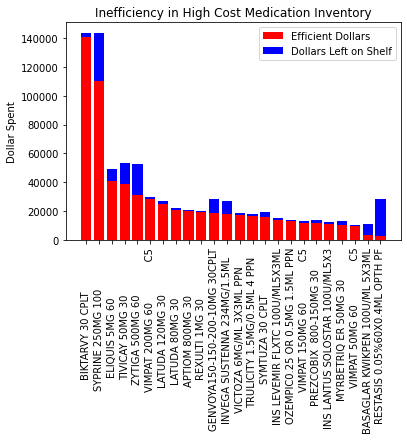

In [330]:
# importing package
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

sorted_effi = sorted_eff[sorted_eff['Dollars on Shelf']>0]
labels = sorted_effi['item']
  
# create data
x = sorted_effi['item']
y1 = sorted_effi['Efficient Dollars']
y2 = sorted_effi['Dollars on Shelf']
  
# plot bars in stack manner
plt.xticks(rotation = 90)
plt.title('Inefficiency in High Cost Medication Inventory')
plt.ylabel('Dollar Spent')

plt.bar(x, y1, color='r')
plt.bar(x, y2, bottom=y1, color='b')

plt.legend(['Efficient Dollars', 'Dollars Left on Shelf'],loc=1)

plt.show()

Obviously a huge amount of money.  Immediately, we will have to examine ordering procedure and find out exactly what is occuring.  

Between both concepts explored, this analysis could potentially save:

Concept One: $3,127.02/month; $37524.24/year

Concept Two: 144,889.55/6 months; >$289,779/year (and likely more due to the fact that only medications with a sum total of over $10,000 was used in this analysis)

Total Savings: ~$327,303/year

Data science works! 